In [1]:
!pip install diffusers hugchat transformers accelerate safetensors --upgrade -q
!pip install git+https://github.com/huggingface/diffusers -q
!pip install ipywidgets -q
!pip install invisible_watermark -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 3.45.0 requires markupsafe~=2.0, but you have markupsafe 3.0.2 which is incompatible.

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from transformers import pipeline
from ipywidgets import interactive, widgets
from IPython.display import HTML, Javascript, Image, display
from google.colab.output import eval_js
import base64
from diffusers import StableDiffusionXLPipeline
import torch

pipe = StableDiffusionXLPipeline.from_pretrained("segmind/SSD-1B", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")
whisper = pipeline("automatic-speech-recognition", model="openai/whisper-large-v2", chunk_length_s=30, device="cuda:0")

ModuleNotFoundError: No module named 'google.colab'

In [3]:
js = Javascript(
    """
    async function recordAudio() {
      const div = document.createElement('div');
      const audio = document.createElement('audio');
      const strtButton = document.createElement('button');
      const stopButton = document.createElement('button');

      strtButton.textContent = 'Start Recording';
      stopButton.textContent = 'Stop Recording';

      document.body.appendChild(div);
      div.appendChild(strtButton);
      div.appendChild(audio);

      const stream = await navigator.mediaDevices.getUserMedia({audio:true});
      let recorder = new MediaRecorder(stream);

      audio.style.display = 'block';
      audio.srcObject = stream;
      audio.controls = true;
      audio.muted = true;

      await new Promise((resolve) => strtButton.onclick = resolve);
        strtButton.replaceWith(stopButton);
        recorder.start();

      await new Promise((resolve) => stopButton.onclick = resolve);
        recorder.stop();
        let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
        let arrBuff = await recData.data.arrayBuffer();
        stream.getAudioTracks()[0].stop();
        div.remove()

        let binaryString = '';
        let bytes = new Uint8Array(arrBuff);
        bytes.forEach((byte) => { binaryString += String.fromCharCode(byte)});

      const url = URL.createObjectURL(recData.data);
      const player = document.createElement('audio');
      player.controls = true;
      player.src = url;
      document.body.appendChild(player);

    return btoa(binaryString)

          };
          """
)

In [5]:
display(js)

output = eval_js('recordAudio({})')
with open('audio.wav', 'wb') as file:
    binary = base64.b64decode(output)
    file.write(binary)
print('Recording saved to:', file.name)
speech_to_text = whisper("audio.wav")

img = speech_to_text['text']


<IPython.core.display.Javascript object>

Recording saved to: audio.wav


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [6]:
print(img)

 chat gpt local generate please


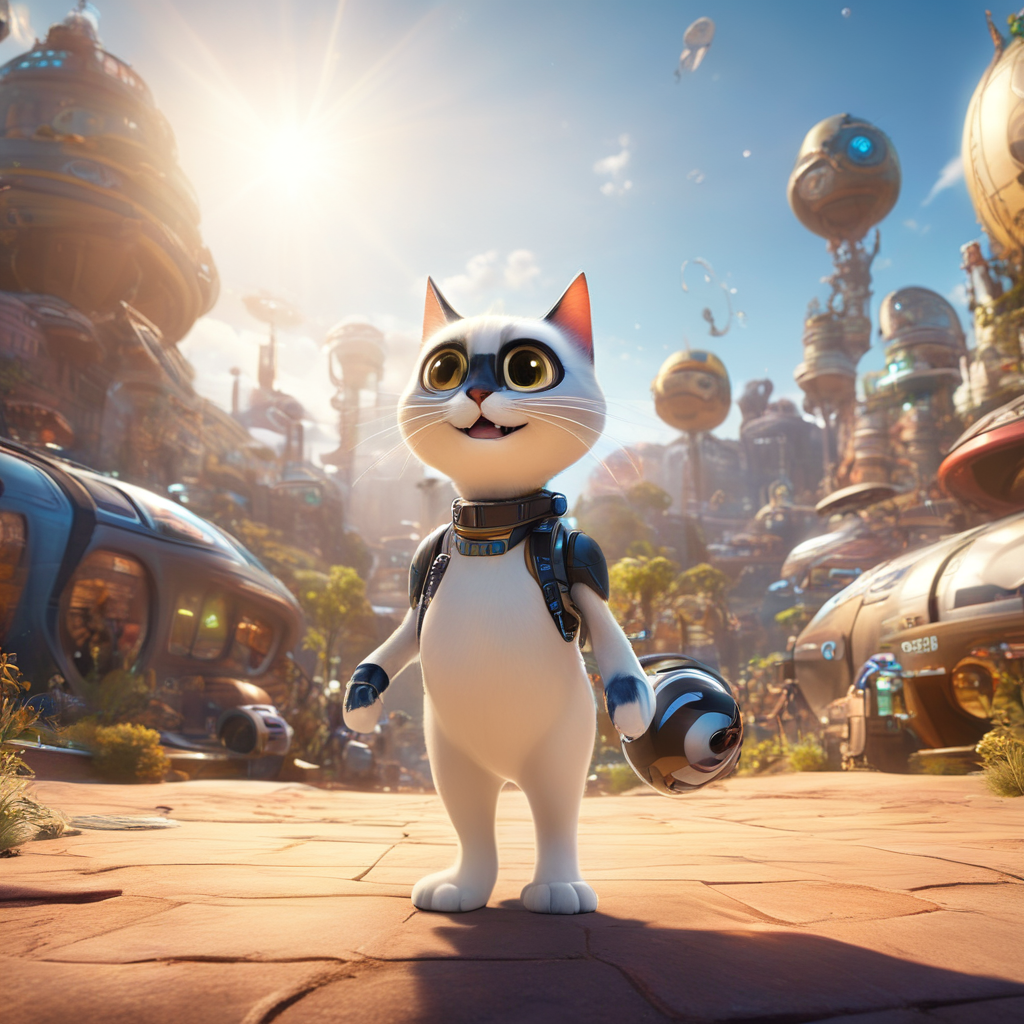

  0%|          | 0/50 [00:00<?, ?it/s]

In [7]:
generated_image = None
image_display = display("", display_id=True)

def generate_image(button):
    global generated_image

    image_style = style_dropdown.value
    image_quality = quality_dropdown.value
    render = render_dropdown.value
    angle = angle_dropdown.value
    lighting = lighting_dropdown.value
    background = background_dropdown.value
    device = device_dropdown.value
    emotion = emotion_dropdown.value

    prompt = f"A stunning {image_style}, {image_quality} shot of {img} captured in {device} using {angle} and rendered by {render}, illuminated by {lighting} light, with {emotion} emotions in a {background} background setting."

    neg_prompt = "ugly, blurry, poor quality, deformed structure, very bad lighting, bad colouring, noise"
    generated_image = pipe(prompt=prompt, negative_prompt=neg_prompt).images[0]

    generated_image.save("generated_image.png")
    final_image_path = "generated_image.png"
    image_display.update(Image(filename=final_image_path))

image_style_options = ["Sci-fi", "photorealistic", "low poly", "cinematic", "cartoon", "graffiti", "sketching"]
image_quality_options = ["High resolution", "8K", "clear", "heavy detailed", "beautiful", "realistic+++", "hyper detailed", "masterpiece"]
render_options = ["Pixar","Octane", "real-time ray tracing", "Christopher Nolan", "James Cameron", "unreal engine", "unity" ]
angle_options = ["Wide-angle lens", "full shot", "Top angle" "Telephoto lens", "Prime lens", "Zoom lens", "Macro lens", "Fisheye lens", "Tilt-shift lens", "Portrait lens", "Anamorphic lens", "Cinematic lens", "Fixed focal length lens", "Variable focal length lens"]
lighting_options = ["Soft", "ambient", "ring" "light", "neon", "Natural", "Soft", "Harsh", "Dramatic", "Backlit", "Studio"]
background_options = ["outdoor", "indoor", "space", "nature", "sci-fi", "neon", "abstract"]
device_options = ["Go Pro", "Iphone 15", "Canon EOS R5","Nikon Z7", "Sony F950", "Drone", "CCTV",]
emotion_options = ["Happy", "Sad", "Angry", "Mysterious", "Surprised", "Annoyed", "Neutral", "dreamy", "nostalgic"]

style_dropdown = widgets.Dropdown(options=image_style_options, description="Style:")
quality_dropdown = widgets.Dropdown(options=image_quality_options, description="Quality:")
render_dropdown = widgets.Dropdown(options=render_options, description="Render by:")
angle_dropdown = widgets.Dropdown(options=angle_options, description="Angle:")
lighting_dropdown = widgets.Dropdown(options=lighting_options, description="Lighting:")
background_dropdown = widgets.Dropdown(options=background_options, description="Background:")
device_dropdown = widgets.Dropdown(options=device_options, description="Device:")
emotion_dropdown = widgets.Dropdown(options=emotion_options, description="Emotion:")

generate_button = widgets.Button(description="Generate Image")

generate_button.on_click(generate_image)

interactive_widget = widgets.VBox([
    style_dropdown, quality_dropdown, angle_dropdown, render_dropdown,
    lighting_dropdown, background_dropdown, device_dropdown, emotion_dropdown,
    generate_button
])

display(interactive_widget)
